In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import importlib.util

spec = importlib.util.spec_from_file_location("util", f"{os.getcwd()}/util.py")
util = importlib.util.module_from_spec(spec)
spec.loader.exec_module(util)

# from util import read_autosleep_data, read_form_data, GrogginessModel, features, target, evaluate_model

In [2]:
person = 'Mark'
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(42)
data = util.read_autosleep_data(person)
suppl = util.read_form_data(person)

merged_data = pd.merge(suppl, data, on='date', how='inner').fillna(0)

merged_data.head(10)

/home/yahiko/code/cs158/grogginess-prediction/util.py:32: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data['date'] = pd.to_datetime(data['ISO8601'], errors='coerce')


,Timestamp,name,date,grogginess,num_alarms,first_alarm,sleep_medicine,waking_temp,intoxicated,sick,...,respMin,respMax,tags,notes,year,month,day,inBed_minutes,day_of_week,is_weekend
0,2/20/2024 2:28:47,Mark,2024-02-19,7,4,540,0,68,0,0,...,11.5,18.5,0.0,0.0,2024,2,19,564.000000,0,0
1,2/20/2024 18:38:08,Mark,2024-02-21,6,3,600,0,68,0,0,...,11.0,16.5,0.0,0.0,2024,2,21,353.000000,2,0
2,2/22/2024 13:31:58,Mark,2024-02-22,8,4,600,0,73,0,0,...,11.5,17.0,0.0,0.0,2024,2,22,533.983333,3,0
3,2/23/2024 14:16:26,Mark,2024-02-23,4,0,0,0,70,1,0,...,13.0,19.5,0.0,0.0,2024,2,23,796.000000,4,0
4,2/25/2024 16:45:03,Mark,2024-02-24,7,2,600,0,70,1,0,...,13.0,19.0,0.0,0.0,2024,2,24,725.000000,5,1
5,2/25/2024 16:45:55,Mark,2024-02-25,4,0,0,0,68,0,0,...,11.0,20.5,0.0,0.0,2024,2,25,836.000000,6,1
6,2/27/2024 3:10:27,Mark,2024-02-26,5,6,540,0,68,0,0,...,12.0,16.0,0.0,0.0,2024,2,26,455.000000,0,0
7,2/27/2024 14:30:15,Mark,2024-02-27,7,6,540,0,68,0,0,...,12.0,16.5,0.0,0.0,2024,2,27,526.000000,1,0
8,3/7/2024 23:24:11,Mark,2024-03-07,7,5,540,0,70,0,0,...,11.0,21.5,0.0,0.0,2024,3,7,715.000000,3,0
9,3/11/2024 0:01:02,Mark,2024-03-10,9,5,300,0,69,0,0,...,12.0,14.5,0.0,0.0,2024,3,10,135.000000,6,1


In [3]:
losses = []
indices = []
accuracies = []

X = merged_data[util.features]
y = merged_data[util.target]
print(X.columns)

Index(['sleepBPM', 'sleepBPMAvg7', 'dayBPM', 'dayBPMAvg7', 'wakingBPM',
       'wakingBPMAvg7', 'hrv', 'hrvAvg7', 'sleepHRV', 'sleepHRVAvg7',
       'SpO2Avg', 'SpO2Min', 'SpO2Max', 'month', 'inBed_minutes',
       'day_of_week', 'is_weekend', 'first_alarm', 'num_alarms',
       'sleep_medicine', 'waking_temp', 'intoxicated', 'sick',
       'eat_before_bed', 'sleep_alone', 'own_bed', 'stress',
       'phone_before_bed', 'caffeine_before_bed', 'grogginess_lag1'],
      dtype='object')


In [4]:
for end_idx in range(2, merged_data.shape[0] + 1):
    temp_data = merged_data.iloc[:end_idx]
    if len(temp_data) < 2:
        continue

    X = temp_data[util.features]
    y = temp_data[util.target]
    split_point = len(X) - 1  # Use the second last row as split point to leave one row for testing
    X_train, X_test = X[:split_point], X[split_point:]
    y_train, y_test = y[:split_point], y[split_point:]
    
    train_dataset = TensorDataset(torch.tensor(X_train.values, dtype=torch.float32).float(), torch.tensor(y_train.values, dtype=torch.float32).float())
    
    val_dataset = TensorDataset(torch.tensor(X_test.values, dtype=torch.float32).float(), torch.tensor(y_test.values, dtype=torch.float32).float())

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

    # Initialize model and optimizer here to ensure they are reset for each iteration
    model = util.GrogginessModel(len(util.features), 64, 1)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    
    # Train the model
    util.train_model(model, train_loader, val_loader)
    
    # Evaluate the model - this function should return both loss and the predicted value for X_test
    val_loss = util.evaluate_model(model, val_loader, criterion)
    prediction = util.make_prediction(model, val_loader).item()
    
    # Get the actual grogginess value for the last day
    actual_grogginess = y_test.iloc[0]  # Assuming y_test is a DataFrame/Series
 
    # Calculate the accuracy as the absolute difference between predicted and actual values
    accuracy = abs(prediction - actual_grogginess).item()  # Ensure this is a scalar value

    # Store the calculated metrics
    accuracies.append(accuracy)
    losses.append(val_loss)
    indices.append(end_idx)

Day 2: Loss: 16.0 Accuracy: 4.0
Day 3: Loss: 48.99997329711914 Accuracy: 6.999998331069946
Day 4: Loss: 9.0 Accuracy: 3.0
Day 5: Loss: 8.880146980285645 Accuracy: 2.9799575805664062
Day 6: Loss: 36.0 Accuracy: 6.0
Day 7: Loss: 24.999589920043945 Accuracy: 4.9999589920043945
Day 8: Loss: 35.999996185302734 Accuracy: 5.999999642372131
Day 9: Loss: 35.797027587890625 Accuracy: 5.983061909675598
Day 10: Loss: 1.0 Accuracy: 1.0
Day 11: Loss: 25.0 Accuracy: 5.0
Day 12: Loss: 16.0 Accuracy: 4.0
Day 13: Loss: 64.0 Accuracy: 8.0
Day 14: Loss: 48.19722366333008 Accuracy: 6.942421793937683
Day 15: Loss: 35.999961853027344 Accuracy: 5.999996662139893
Day 16: Loss: 49.0 Accuracy: 7.0
Day 17: Loss: 36.0 Accuracy: 6.0
Day 18: Loss: 16.0 Accuracy: 3.9999998807907104
Day 19: Loss: 8.739916801452637 Accuracy: 2.9563350677490234
Day 20: Loss: 9.0 Accuracy: 3.0
Day 21: Loss: 0.0005297241732478142 Accuracy: 0.023015737533569336
Day 22: Loss: 16.0 Accuracy: 4.0
Day 23: Loss: 36.0 Accuracy: 6.0
Day 24: Loss:

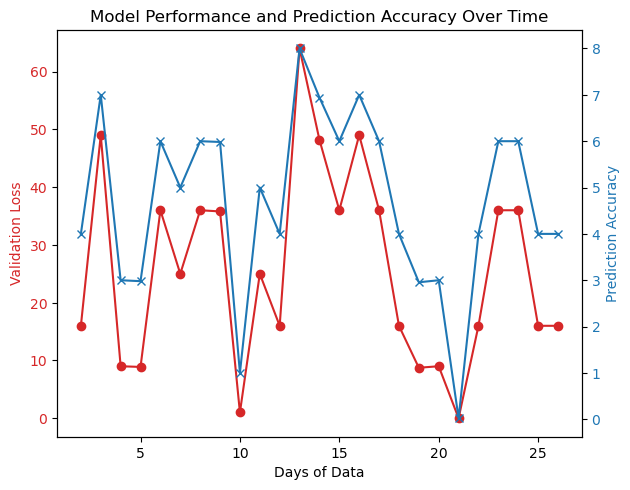

In [5]:
for loss, day, accuracy in zip(losses, indices, accuracies):
    print(f'Day {day}: Loss: {loss} Accuracy: {accuracy}')
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Days of Data')
ax1.set_ylabel('Validation Loss', color=color)
ax1.plot(indices, losses, marker='o', linestyle='-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Prediction Accuracy', color=color)  # We already handled the x-label with ax1
ax2.plot(indices, accuracies, marker='x', linestyle='-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # To ensure there's no overlap
plt.title('Model Performance and Prediction Accuracy Over Time')
plt.show()

In [6]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import importlib.util

spec = importlib.util.spec_from_file_location("util", f"{os.getcwd()}/util.py")
util = importlib.util.module_from_spec(spec)
spec.loader.exec_module(util)

# from util import read_autosleep_data, read_form_data, GrogginessModel, features, target, evaluate_model